## Figure 6: Model performance

This notebook reproduces Figure 6, using code largely taken from `01-create_pu_classifier.ipynb` and `01b-cross_validation.ipynb`.

In [1]:
import os
import warnings
from string import ascii_uppercase

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pulearn.bagging import BaggingPuClassifier
from sklearn.base import clone
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC

from lib.pu import (
    BASE_MODELS,
    downsample_unlabelled,
    get_xy,
)

# Suppress FutureWarning for some versions of Scikit-learn
%env PYTHONWARNINGS=ignore::FutureWarning
warnings.simplefilter("ignore", FutureWarning)

env: PYTHONWARNINGS=ignore::FutureWarning


In [2]:
# Random seed for reproducibility
random_seed = 1234

# Number of jobs used to train model
n_jobs = 8

In [3]:
# Input/output files

data_filename = "training_data.csv"
output_dir = os.path.join("outputs", "figures")
if not os.path.isdir(output_dir):
    os.makedirs(output_dir, exist_ok=True)
output_basename = os.path.join(output_dir, "model_performance")

### Load and process training data

In [4]:
data = pd.read_csv(data_filename)

# Restrict unlabelled training data to the Americas
data = data[data["region"].isin({"NAm", "SAm"})]

# Equal number of positive and unlabelled samples
data = downsample_unlabelled(data, random_state=random_seed)

print(data.groupby(["region", "label"]).size())

region  label     
NAm     negative       57
        positive      217
        unlabelled    183
SAm     negative      632
        positive      130
        unlabelled    164
dtype: int64


In [5]:
stratify = (
    data["region"]
    + "_"
    + data["label"]
)
data_train, data_test = train_test_split(
    data,
    test_size=0.2,
    random_state=random_seed,
    shuffle=True,
    stratify=stratify,
)

data_test = data_test[data_test["label"].isin({"positive", "negative"})]
indices_NA = np.where(data_test["region"] == "NAm")[0]
indices_SA = np.where(data_test["region"] == "SAm")[0]

x_test, y_test = get_xy(data_test)

In [6]:
pd.concat(
    (
        data_train.assign(set="train"),
        data_test.assign(set="test"),
    )
).groupby(["set", "region", "label"]).size()

set    region  label     
test   NAm     negative       11
               positive       43
       SAm     negative      127
               positive       26
train  NAm     negative       46
               positive      174
               unlabelled    146
       SAm     negative      505
               positive      104
               unlabelled    131
dtype: int64

### Train models

In [7]:
# Scaling not necessary for RF, but kept for consistency
scaler = RobustScaler()

base_model = clone(BASE_MODELS["randomforest"])
base_model.set_params(random_state=random_seed)
model_pu = BaggingPuClassifier(
    base_model,
    n_jobs=n_jobs,
    random_state=random_seed,
    n_estimators=250,
    max_samples=1.0,
)
model_pu = make_pipeline(clone(scaler), model_pu)

model_svm = SVC(
    kernel="rbf",
    probability=True,
    random_state=random_seed,
)
model_svm = make_pipeline(clone(scaler), model_svm)

In [8]:
train_pu = data_train[
    data_train["label"].isin({"positive", "unlabeled", "unlabelled"})
]
x_train_pu, y_train_pu = get_xy(train_pu)
train_svm = data_train[
    data_train["label"].isin({"positive", "negative"})
]
x_train_svm, y_train_svm = get_xy(train_svm)

model_pu.fit(x_train_pu, y_train_pu)
model_svm.fit(x_train_svm, y_train_svm)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('svc', SVC(probability=True, random_state=1234))])

### Test and visualise model performance

In [9]:
probs_pu = model_pu.predict_proba(x_test)[:, 1]
probs_pu_NA = probs_pu[indices_NA]
probs_pu_SA = probs_pu[indices_SA]

probs_svm = model_svm.predict_proba(x_test)[:, 1]
probs_svm_NA = probs_svm[indices_NA]
probs_svm_SA = probs_svm[indices_SA]

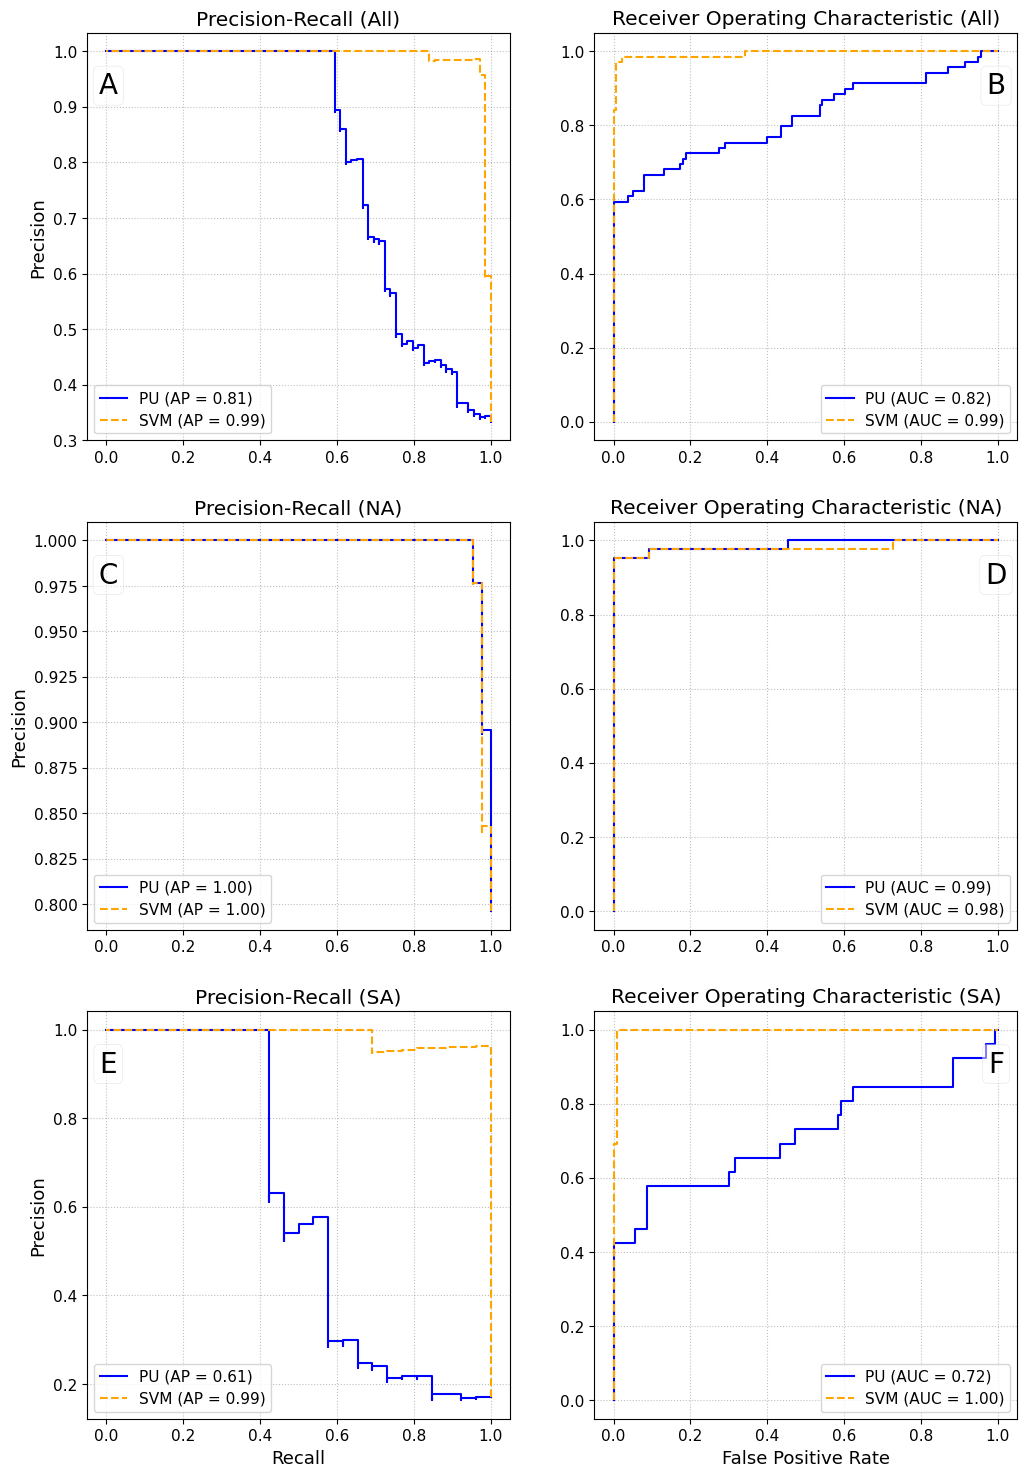

In [10]:
title_size = 14.5
caption_size = 20
label_size = 13
tick_size = 11

regions = ("All", "NA", "SA")
values_dict = {
    "All": y_test,
    "NA": y_test[indices_NA],
    "SA": y_test[indices_SA],
}
probs_dict = {
    "All": {"PU": probs_pu, "SVM": probs_svm},
    "NA": {"PU": probs_pu_NA, "SVM": probs_svm_NA},
    "SA": {"PU": probs_pu_SA, "SVM": probs_svm_SA},
}
kwargs_dict = {
    "PU": {"color": "blue", "linestyle": "solid"},
    "SVM": {"color": "orange", "linestyle": "dashed"},
}
titles_dict = {
    PrecisionRecallDisplay: "Precision-Recall",
    RocCurveDisplay: "Receiver Operating Characteristic",
}

fig, axs = plt.subplots(3, 2, figsize=(12, 18))
for i, region in enumerate(regions):
    row = axs[i]
    values = values_dict[region]
    probs = probs_dict[region]
    for j, (ax, which) in enumerate(
        zip(
            row,
            (
                PrecisionRecallDisplay,
                RocCurveDisplay,
            ),
        )
    ):
        for model in ("PU", "SVM"):
            which.from_predictions(
                values,
                probs[model],
                name=model,
                ax=ax,
                **(kwargs_dict[model]),
            )
        ax.grid(
            linestyle="dotted",
            color="grey",
            alpha=0.5,
        )
        ax.set_title(
            f"{titles_dict[which]} ({region})",
            fontsize=title_size,
        )
        if i == 2:
            xlabel = ax.get_xlabel().replace(
                " (Positive label: 1)",
                "",
            )
        else:
            xlabel = ""
        if j == 0:
            ylabel = ax.get_ylabel().replace(
                " (Positive label: 1)",
                "",
            )
            label_x = 0.05
        else:
            ylabel = ""
            label_x = 0.95
        ax.set_xlabel(xlabel, fontsize=label_size)
        ax.set_ylabel(ylabel, fontsize=label_size)
        ax.text(
            label_x,
            0.87,
            ascii_uppercase[(i * 2) + j],
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=caption_size,
            bbox=dict(
                facecolor="white",
                edgecolor="lightgrey",
                linewidth=0.5,
                boxstyle="Round, pad=0.2, rounding_size=0.2",
                alpha=0.5,
            )
        )
        ax.tick_params(labelsize=tick_size)
        for t in ax.get_legend().get_texts():
            t.set_fontsize(tick_size)

for ext in (".png", "pdf"):
    fig.savefig(output_basename + ext, dpi=350, bbox_inches="tight")